In [1]:
# Includes libraries
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## Utils Functions

In [3]:
def find_weeks(dataframe):
    """
    Find the successive rows which are in the same week

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe containing the data

    Returns
    -------
    pandas.DataFrame
        The dataframe containing the data with the week number
    """
    keys = ["Date"] + dataframe.columns.tolist()
    week = []
    
    # Create a dataframe to store the weekly data
    df_cycle = pd.DataFrame()

    # Iterate through the dataframe
    for i_date, i_values in dataframe.iterrows():
        # Check if current date is monday
        is_monday = i_date.day_of_week == 0
        
        # Check if current date is friday and the data_week contains previous 4 days
        is_friday = len(week) == 4 and i_date.day_of_week == 4

        # Check if the date is next day of the last date in data_week
        is_next_day = len(week) != 0 and week[-1][0] + datetime.timedelta(days=1) == i_date

        # Fill the week list with i_values
        if is_monday or is_friday or is_next_day:
            week = [] if is_monday else week
            week += [[i_date] + i_values.values.tolist()]

        # If the week contains 5 days, add it to the dataframe
        if len(week) == 5:
            df_week = pd.DataFrame(week, columns=keys)
            df_cycle = pd.concat([df_cycle, df_week], axis=0)
            week = []

    return df_cycle


def group_weeks(dataframe):
    """
    Concatenate the rows that are in the same week

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe containing the data

    Returns
    -------
    pandas.DataFrame
        The dataframe containing the data with the week number
    """
    df_cyclic = dataframe.drop(columns=["Company", "Date"])
    df_weeks = pd.DataFrame()

    # Create column names containing the week number
    columns = []

    for j in range(5):
        for i in range(df_cyclic.shape[1]):
            columns += [df_cyclic.columns[i] + "_" + str(j)]

    # Iterate every 5 rows to create a dataframe for each week
    for i in range(0, len(df_cyclic), 5):
        # Create a series containing the week data
        week = np.append(df_cyclic[i:i+5].values, dataframe["Company"].iloc[i]).reshape(1, -1)
        week = np.insert(week, 0, dataframe["Date"].iloc[i].date(), axis=1)
        week = pd.DataFrame(week)

        # Add the week series to the weeks dataframe
        df_weeks = pd.concat([df_weeks, week], axis=0)

    df_weeks.columns = ["Date"] + columns + ["Company"]

    return df_weeks.reset_index(drop=True)

## I. Data Preprocessing

In [21]:
# Set the path to the data
path = "data/"

# Write data into a dataframe
dataframe = pd.DataFrame()

for file in os.listdir(path):
    df_read = pd.read_csv(path + file, sep = ",")
    df_read["Company"] = file.split("(")[0]
    df_read["Date"] = pd.to_datetime(df_read["Date"])
    df_read.set_index("Date", inplace=True)
    df_read = find_weeks(df_read)
    df_read = group_weeks(df_read)

    dataframe = pd.concat([dataframe, df_read], axis=0)

# Set the date as the index
dataframe["Date"] = pd.to_datetime(dataframe["Date"])
dataframe.set_index("Date", inplace=True)

# Convert the columns to numeric except the 'Company' column
numeric_columns = dataframe.columns[dataframe.columns != "Company"]
dataframe[numeric_columns] = dataframe[numeric_columns].astype(float)

# Save the dataframe as a csv file
# dataframe.to_csv("weekly_data.csv")

dataframe.head()

,Open_0,High_0,Low_0,Close_0,Adj Close_0,Volume_0,Open_1,High_1,Low_1,Close_1,...,Close_3,Adj Close_3,Volume_3,Open_4,High_4,Low_4,Close_4,Adj Close_4,Volume_4,Company
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-07,13.266705,13.386636,12.938321,13.143918,11.812600,5607402.0,13.212450,13.375214,12.941176,12.981154,...,12.327242,11.078644,8888076.0,12.370074,12.484295,12.233010,12.390063,11.135103,4904551.0,MTCH
2013-01-14,12.412907,12.418618,12.238721,12.412907,11.155633,3008568.0,12.364363,12.412907,12.075957,12.198744,...,11.944603,10.734760,5452964.0,11.961736,11.973158,11.841805,11.910337,10.703967,2431439.0,MTCH
2013-01-28,11.553398,11.793261,11.507710,11.616219,10.439638,4930116.0,11.659052,11.687607,11.427756,11.607653,...,11.778983,10.585918,5420746.0,11.887493,11.970303,11.707596,11.867504,10.665475,3514257.0,MTCH
2013-02-04,11.747573,11.881782,11.681896,11.753284,10.562821,3747840.0,11.821816,12.247287,11.810394,12.104512,...,12.527127,11.258285,11385702.0,12.504283,12.627070,11.878926,12.484295,11.219791,9349640.0,MTCH
2013-02-11,12.541405,12.561393,12.361508,12.421473,11.163330,7001198.0,12.361508,12.378641,12.107367,12.230154,...,11.870360,10.728155,5948497.0,11.847516,11.996002,11.767561,11.907481,10.761705,6708431.0,MTCH


In [2]:
# Load the dataframes already saved
dataframe = pd.read_csv("weekly_data.csv")

In [3]:
print(f"Total number of missing values: {dataframe.isnull().sum().sum()}")
dataframe.drop(["Company"], axis=1).describe()

Total number of missing values: 0


,Open_0,High_0,Low_0,Close_0,Adj Close_0,Volume_0,Open_1,High_1,Low_1,Close_1,...,Low_3,Close_3,Adj Close_3,Volume_3,Open_4,High_4,Low_4,Close_4,Adj Close_4,Volume_4
count,12576.000000,12576.000000,12576.000000,12576.000000,12576.000000,1.257600e+04,12576.000000,12576.000000,12576.000000,12576.000000,...,12576.000000,12576.000000,12576.000000,1.257600e+04,12576.000000,12576.000000,12576.000000,12576.000000,12576.000000,1.257600e+04
mean,78.055401,79.059313,77.050397,78.115126,74.813691,3.173252e+07,78.235989,79.183661,77.219097,78.203377,...,77.202958,78.216668,74.921602,3.285176e+07,78.253644,79.144698,77.190071,78.179601,74.885862,3.438584e+07
std,75.587629,76.675148,74.488578,75.710433,75.987190,4.856106e+07,75.815509,76.824855,74.727377,75.794895,...,74.674221,75.711573,75.989412,4.828235e+07,75.734394,76.635671,74.578126,75.610566,75.886549,5.108344e+07
min,1.670000,1.700000,1.610000,1.620000,1.620000,1.436000e+05,1.620000,1.690000,1.620000,1.660000,...,1.660000,1.700000,1.700000,1.749000e+05,1.680000,1.750000,1.650000,1.670000,1.670000,1.341000e+05
25%,28.345625,28.641996,27.967681,28.287501,25.007929,6.118600e+06,28.306545,28.663370,27.990702,28.326427,...,28.035520,28.360001,25.078379,6.430675e+06,28.375872,28.700001,28.064085,28.382764,25.148379,6.529200e+06
50%,52.860001,53.563001,52.180000,52.904999,49.470890,1.681095e+07,52.980000,53.681249,52.207175,53.003750,...,52.270000,53.070000,49.698305,1.748610e+07,53.014999,53.664999,52.392876,53.013001,49.631620,1.810615e+07
75%,101.884998,103.000000,100.560001,101.612501,97.653346,3.699230e+07,102.000000,103.099998,100.802502,101.929998,...,101.042502,102.232502,98.006184,3.876410e+07,102.121876,103.270998,101.029999,102.130003,97.904793,4.079450e+07
max,689.059998,689.969971,676.539978,681.169983,681.169983,7.855176e+08,683.109985,688.359985,676.900024,687.400024,...,679.739990,682.020020,682.020020,7.599116e+08,692.349976,694.159973,675.000000,690.309998,690.309998,7.640976e+08


In [4]:
# Label encode the company column
enc = OneHotEncoder(handle_unknown="error")
company_encoded = enc.fit_transform(dataframe[["Company"]]).toarray()
df_company_encoded = pd.DataFrame(company_encoded, columns=enc.get_feature_names_out())
dataframe_enc = pd.concat([dataframe, df_company_encoded], axis=1)
dataframe_enc.drop(["Company"], axis=1, inplace=True)

In [5]:
dataframe_enc.head()

,Date,Open_0,High_0,Low_0,Close_0,Adj Close_0,Volume_0,Open_1,High_1,Low_1,...,Company_NVDA,Company_PFE,Company_PYPL,Company_T,Company_TSLA,Company_TTD,Company_WMT,Company_XOM,Company_YELP,Company_ZG
0,2013-01-07,13.266705,13.386636,12.938321,13.143918,11.812600,5607402.0,13.212450,13.375214,12.941176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-14,12.412907,12.418618,12.238721,12.412907,11.155633,3008568.0,12.364363,12.412907,12.075957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-28,11.553398,11.793261,11.507710,11.616219,10.439638,4930116.0,11.659052,11.687607,11.427756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-02-04,11.747573,11.881782,11.681896,11.753284,10.562821,3747840.0,11.821816,12.247287,11.810394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-02-11,12.541405,12.561393,12.361508,12.421473,11.163330,7001198.0,12.361508,12.378641,12.107367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Select the features and the target
X = dataframe_enc.drop(["Date", "Open_4", "High_4", "Low_4", "Close_4", "Adj Close_4", "Volume_4"], axis=1)
y = dataframe_enc["Close_4"]

# Split the data into train, test and validation sets.
# Train set: 70%, Validation set: ~20%, Test set: ~10%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, shuffle=True)

(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((8803, 54), (8803,)), ((2641, 54), (2641,)), ((1132, 54), (1132,)))

In [7]:
# Standardize the data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

The number of principal components is: 54


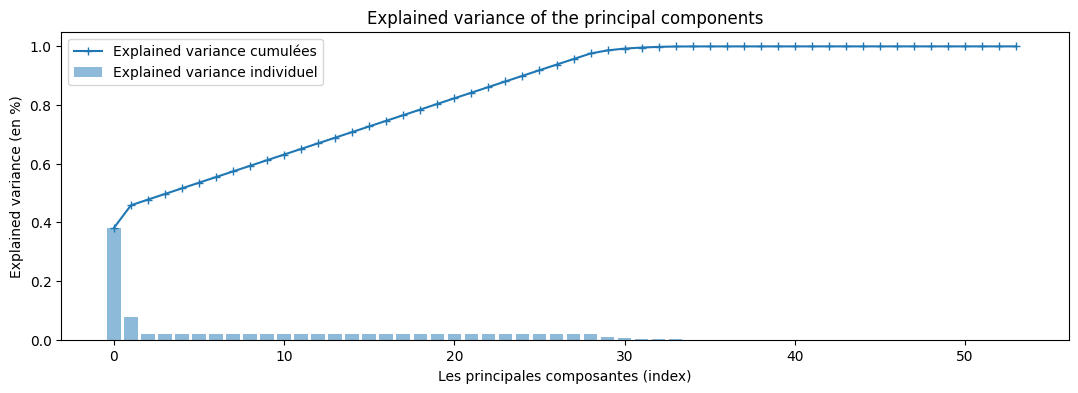

In [8]:
# Application of the PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
print(f"The number of principal components is: {pca.n_components_}")

# Visualization of the explained variance of the principal components
exp_var_pca = pca.explained_variance_ratio_

plt.figure(figsize=(13, 4))
plt.bar(range(len(exp_var_pca)), height=exp_var_pca, label="Explained variance individuel", alpha=.5)
plt.plot(np.cumsum(exp_var_pca), marker="+", label="Explained variance cumulées")
plt.xlabel("Les principales composantes (index)")
plt.ylabel("Explained variance (en %)")
plt.title("Explained variance of the principal components")
plt.legend()
plt.show()

After analysing the above graph, we can see that the best n_components is 29, because after that the explained variance is almost constant.

In [9]:
# Application of the PCA with 29 components
pca = PCA(n_components=29)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

## II. Data Visualization

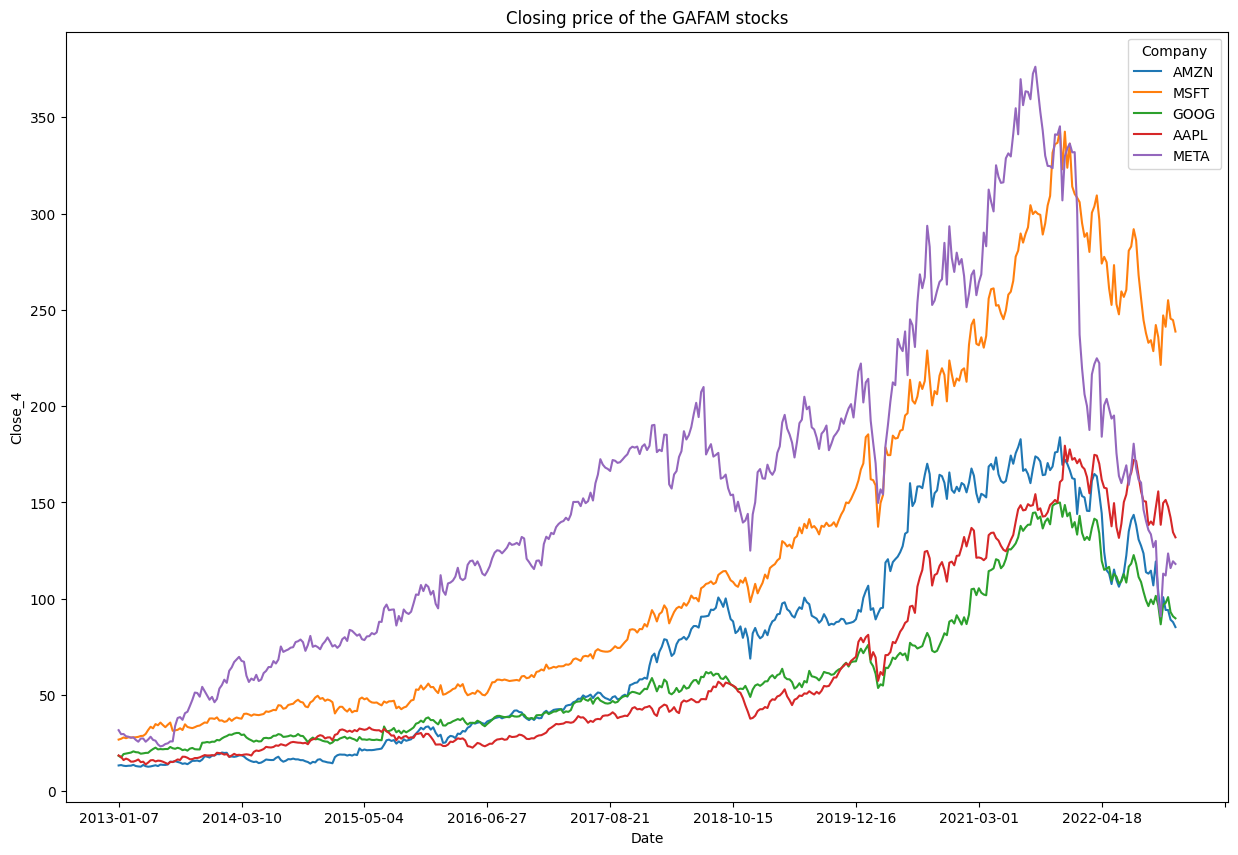

In [10]:
GAFAM = ["GOOG", "AMZN", "META", "AAPL", "MSFT"]
GAFAM = dataframe[dataframe["Company"].isin(GAFAM)]

# Plot the closing price of the GAFAM stocks
plt.figure(figsize=(15, 10))
ax = sns.lineplot(x="Date", y="Close_4", hue="Company", data=GAFAM)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.title("Closing price of the GAFAM stocks")
plt.show()

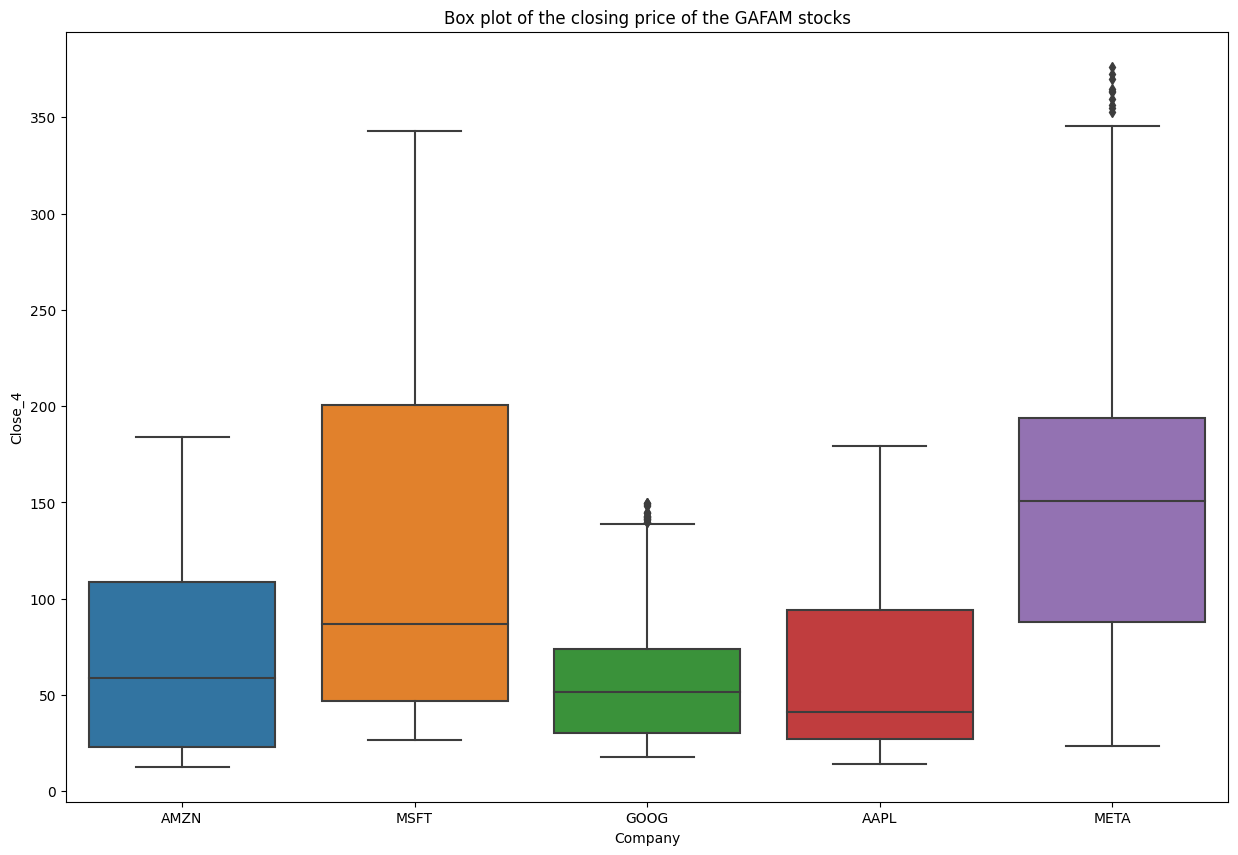

In [11]:
# Plot the box plot
plt.subplots(figsize=(15, 10))
sns.boxplot(x="Company", y="Close_4", data=GAFAM)
plt.title("Box plot of the closing price of the GAFAM stocks")
plt.show()

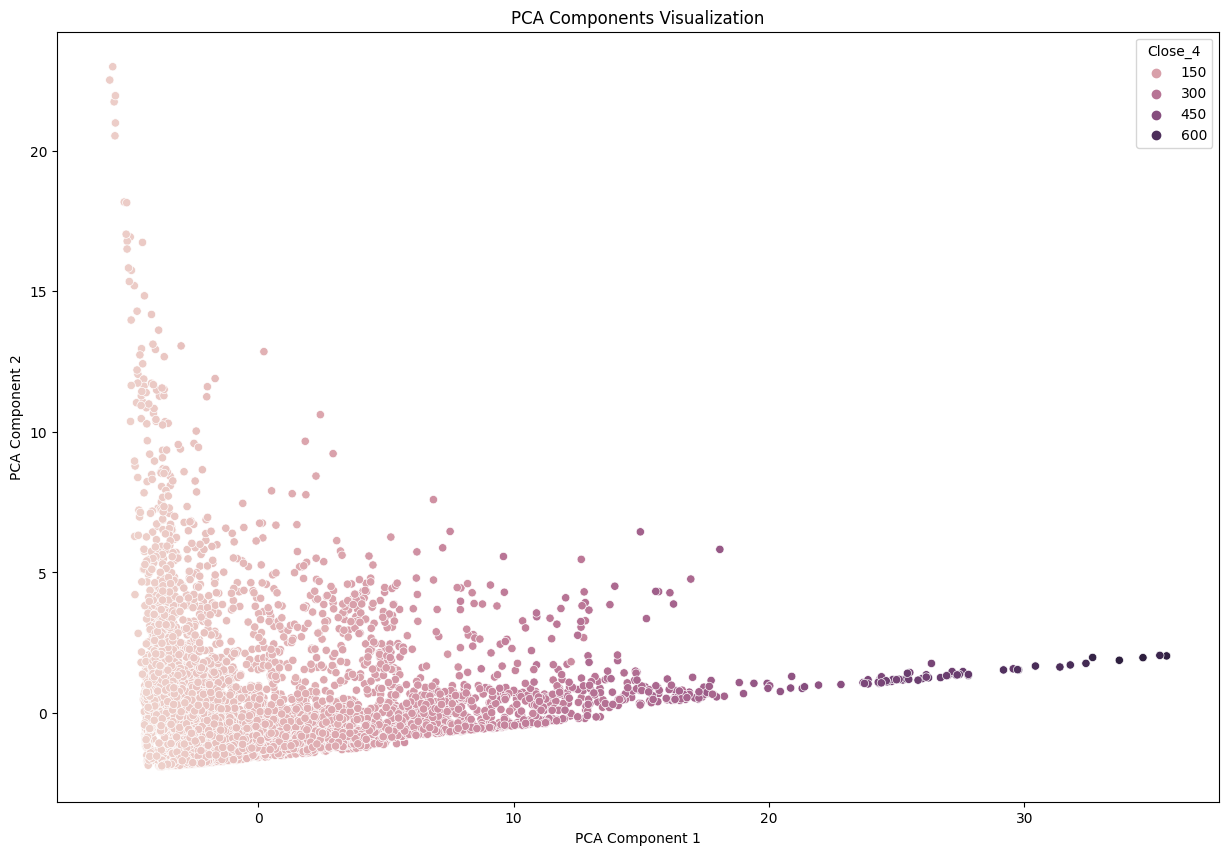

In [12]:
# PCA Components Visualization
plt.figure(figsize=(15, 10))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)
plt.title("PCA Components Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

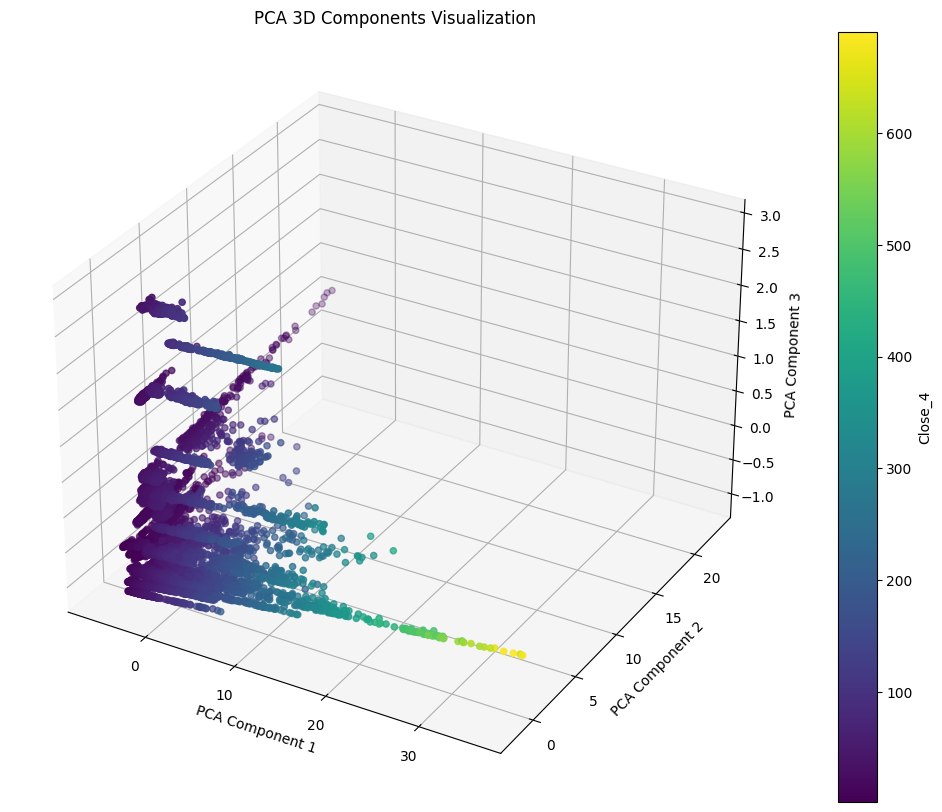

In [13]:
# PCA 3D Components Visualization
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, label="Close_4")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
cbar = plt.colorbar(scatter)
cbar.set_label("Close_4")
plt.title("PCA 3D Components Visualization")
plt.show()

In [14]:
# Define the model
lr = LinearRegression()

cr = lr.fit(X_train_pca, y_train)
print(f"MSE Train: {mean_squared_error(y_train, lr.predict(X_train_pca))}")
print(f"MSE Valid: {mean_squared_error(y_val, lr.predict(X_val_pca))}")

MSE Train: 17.89369934323792
MSE Valid: 15.568581856132115


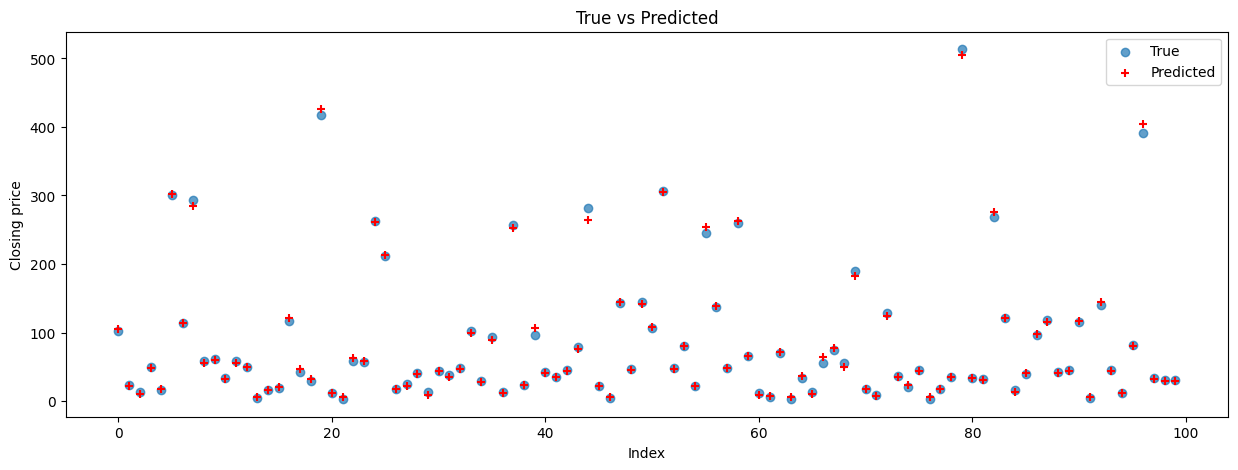

In [15]:
n = 100
y_pred = lr.predict(X_val_pca)
rand_ids = np.random.randint(0, len(X_val_pca), size=n)

plt.figure(figsize=(15, 5))
plt.scatter(x=range(n), y=y_val.values[rand_ids], label="True", alpha=.7)
plt.scatter(x=range(n), y=y_pred[rand_ids], label="Predicted", alpha=1, marker="+", c="red")
plt.legend()
plt.title("True vs Predicted")
plt.xlabel("Index")
plt.ylabel("Closing price")
plt.show()